# Este notebook aplica o mesmo método que 01b, mas trocando para base aumentada e filtrada (redução de erros de rótulo) produzida por 02c e o2d2

In [1]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, \
    ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile


from sklearn.metrics import classification_report, confusion_matrix

MODEL_DIR = '../models'
LOG_DIR = '../logs/01b3/'


caminho_bases = os.path.join('..', 'bases', 'vazios_augmented2')
caminho_train = os.path.join(caminho_bases, 'train')
caminho_test = os.path.join(caminho_bases, 'test')

# Callbacks

In [2]:
tensorboard_logs = TensorBoard(log_dir=LOG_DIR, histogram_freq=1,
                               write_graph=False, write_images=False,
                               update_freq='epoch')
mcp_save = ModelCheckpoint(os.path.join(MODEL_DIR, 
                                        'B3modelweights.{epoch:02d}-{val_loss:.2f}.hdf5'),
                           save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=0, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                              verbose=1, mode='min')


# Model

In [3]:
SIZE = (224, 224)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3),
                         padding='same',
                         activation='relu',
                         input_shape=(*SIZE, 3)),
  MaxPooling2D(pool_size=(2, 2)),
  Conv2D(32, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.2),
  Conv2D(64, (3, 3), padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), padding='same', activation='relu'),
#  Conv2D(128, (1, 1), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(128, (3, 3), activation='relu'),
#  Conv2D(128, (1, 1), activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(256, (3, 3), activation='relu'),
#  GlobalAveragePooling2D(),
  Flatten(),
  Dense(256, activation='relu'),
  Dropout(0.4),
  Dense(1, activation='sigmoid')
 
])

model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

# Training and validation

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    caminho_train,
    target_size=SIZE,
    batch_size=128,
    class_mode='binary'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    caminho_test,
    target_size=SIZE,
    batch_size=32,
    class_mode='binary'
)

Found 41016 images belonging to 2 classes.
Found 4544 images belonging to 2 classes.


In [5]:
epoch = 6

In [6]:
val_loss = 0.09
model.load_weights(
    os.path.join(MODEL_DIR,
                 'B2modelweights.{:02d}-{:.2f}.hdf5'.format(epoch, val_loss)
                ))

In [7]:
history = model.fit_generator(train_generator,
                               initial_epoch=epoch,
                              epochs=30,
                              verbose=1,
                              callbacks=[early_stop, mcp_save, reduce_lr, tensorboard_logs],
                              validation_data=validation_generator)

Epoch 7/30


W0709 20:57:47.554683 139955269498624 deprecation.py:323] From /home/ivan/pybr/projeto/venv/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


321/321 [==============================] - 869s 3s/step - loss: 0.1092 - acc: 0.9716 - val_loss: 0.0887 - val_acc: 0.9773
Epoch 8/30
321/321 [==============================] - 130s 404ms/step - loss: 0.1077 - acc: 0.9721 - val_loss: 0.0890 - val_acc: 0.9776
Epoch 9/30
321/321 [==============================] - 129s 403ms/step - loss: 0.1059 - acc: 0.9725 - val_loss: 0.0883 - val_acc: 0.9776
Epoch 10/30
321/321 [==============================] - 130s 405ms/step - loss: 0.1062 - acc: 0.9725 - val_loss: 0.0879 - val_acc: 0.9780
Epoch 11/30
321/321 [==============================] - 130s 405ms/step - loss: 0.1052 - acc: 0.9726 - val_loss: 0.0873 - val_acc: 0.9778
Epoch 12/30
321/321 [==============================] - 130s 404ms/step - loss: 0.1043 - acc: 0.9730 - val_loss: 0.0868 - val_acc: 0.9782
Epoch 13/30
321/321 [==============================] - 130s 405ms/step - loss: 0.1034 - acc: 0.9733 - val_loss: 0.0868 - val_acc: 0.9780
Epoch 14/30
321/321 [==============================] - 130

# Evaluation

In [8]:
from utils import get_imagens_erro, report, plot_errors
import time

validation_generator = validation_datagen.flow_from_directory(
    caminho_test,
    target_size=SIZE,
    batch_size=64,
    class_mode='binary',
    shuffle=False
)
s = len(validation_generator) * 64
t0 = time.time()
y_test, y_pred, X_names_test, y_pred_proba = get_imagens_erro(validation_generator, model)
elapsed = time.time() - t0
print('%d imagens processadas em %s segundos (%s por imagem)' % (s, elapsed, elapsed / s))

Found 4544 images belonging to 2 classes.
4544 imagens processadas em 11.121387004852295 segundos (0.0024474883373354524 por imagem)


In [9]:
report(validation_generator, y_test, y_pred)

{0: 'nvazio', 1: 'vazio'}
R/P 	 nvazio 	 vazio 
nvazio 	 2150 	 94
vazio 	 0 	 2300
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      2244
         1.0       0.96      1.00      0.98      2300

    accuracy                           0.98      4544
   macro avg       0.98      0.98      0.98      4544
weighted avg       0.98      0.98      0.98      4544



{0: 'nvazio', 1: 'vazio'}


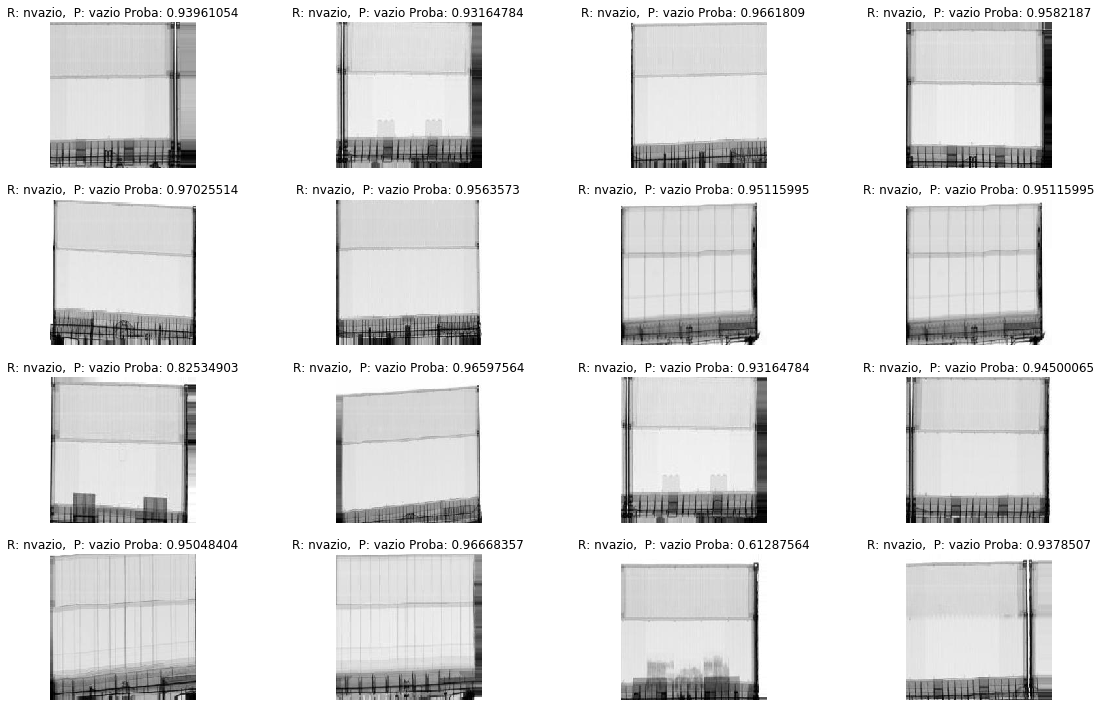

In [10]:
from utils import plot_errors
plot_errors(validation_generator, y_test, y_pred, caminho_test, X_names_test, y_pred_proba)

In [11]:
train_generator = train_datagen.flow_from_directory(
    caminho_train,
    target_size=SIZE,
    batch_size=128,
    class_mode='binary',
    shuffle=False
)

s = len(train_generator) * 128
t0 = time.time()

y_train, y_pred_train, X_names_train, y_pred_train_proba = get_imagens_erro(train_generator, model)

elapsed = time.time() - t0
print('%d imagens processadas em %s segundos (%s por imagem)' % (s, elapsed, elapsed / s))

Found 41016 images belonging to 2 classes.
9088 imagens processadas em 95.93422484397888 segundos (0.010556142698501197 por imagem)


In [12]:
report(train_generator, y_train, y_pred_train)

{0: 'nvazio', 1: 'vazio'}
R/P 	 nvazio 	 vazio 
nvazio 	 19269 	 1063
vazio 	 2 	 20682
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97     20332
         1.0       0.95      1.00      0.97     20684

    accuracy                           0.97     41016
   macro avg       0.98      0.97      0.97     41016
weighted avg       0.98      0.97      0.97     41016



{0: 'nvazio', 1: 'vazio'}


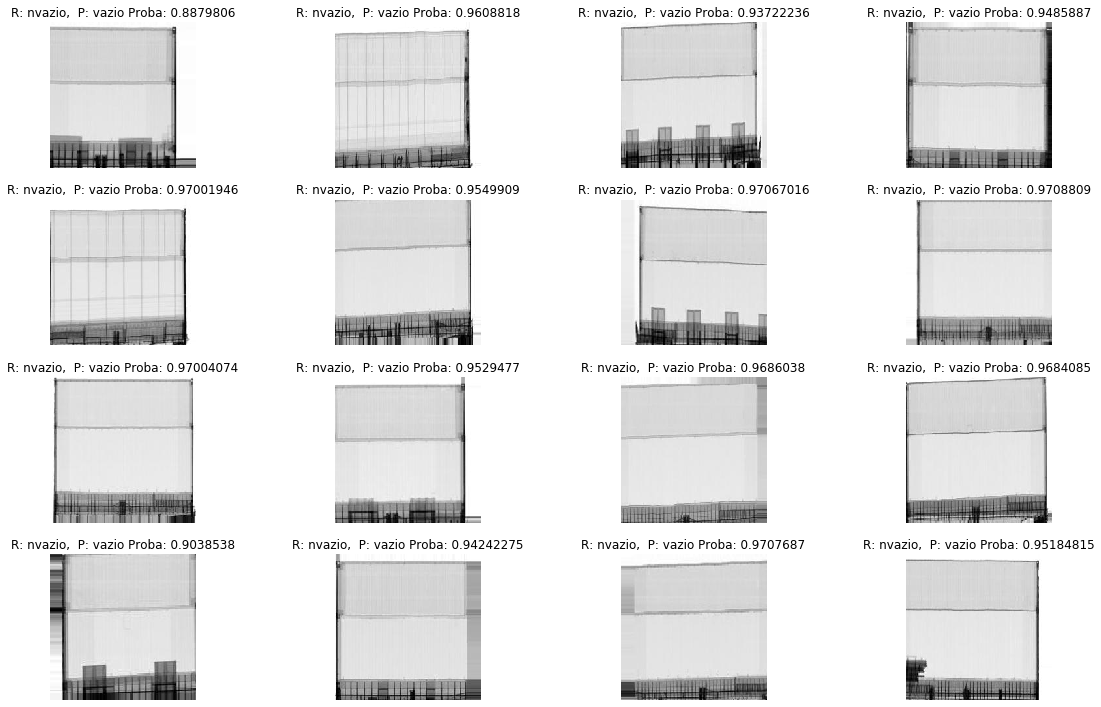

In [13]:
plot_errors(train_generator, y_train, y_pred_train, caminho_train, X_names_train, y_pred_train_proba)

# Testar na base original!!!
### ( sem transformações )

In [14]:
caminho_basest = os.path.join('..', 'bases', 'vazios')
caminho_traint = os.path.join(caminho_basest, 'train')
caminho_testt = os.path.join(caminho_basest, 'test')

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

validation_generator = validation_datagen.flow_from_directory(
    caminho_testt,
    target_size=SIZE,
    batch_size=64,
    class_mode='binary',
    shuffle=False
)
s = len(validation_generator) * 64
t0 = time.time()
y_test, y_pred, X_names_test, y_pred_proba = get_imagens_erro(validation_generator, model)
elapsed = time.time() - t0
print('%d imagens processadas em %s segundos (%s por imagem)' % (s, elapsed, elapsed / s))

Found 2317 images belonging to 2 classes.
2368 imagens processadas em 7.745938777923584 segundos (0.0032710890109474595 por imagem)


In [16]:
report(validation_generator, y_test, y_pred)

{0: 'nvazio', 1: 'vazio'}
R/P 	 nvazio 	 vazio 
nvazio 	 1075 	 91
vazio 	 0 	 1151
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      1166
         1.0       0.93      1.00      0.96      1151

    accuracy                           0.96      2317
   macro avg       0.96      0.96      0.96      2317
weighted avg       0.96      0.96      0.96      2317



{0: 'nvazio', 1: 'vazio'}


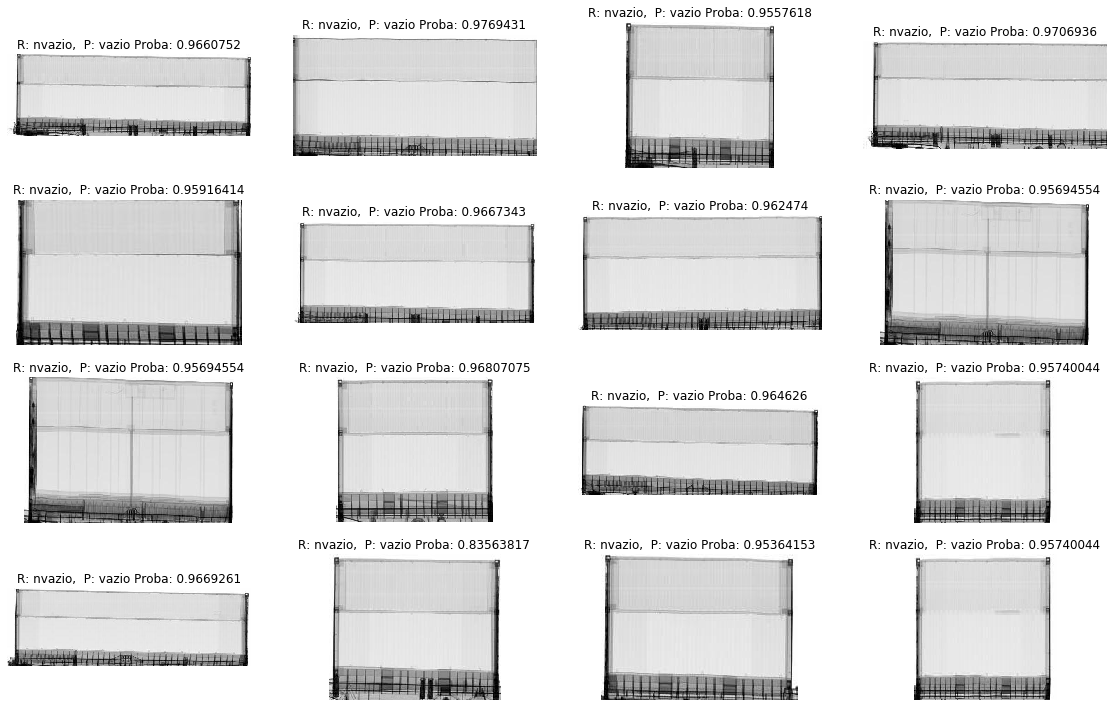

In [17]:
plot_errors(validation_generator, y_test, y_pred, caminho_testt, X_names_test, y_pred_proba)

In [18]:
train_generator = train_datagen.flow_from_directory(
    caminho_traint,
    target_size=SIZE,
    batch_size=128,
    class_mode='binary',
    shuffle=False
)

s = len(train_generator) * 128
t0 = time.time()

y_train, y_pred_train, X_names_train, y_pred_train_proba = get_imagens_erro(train_generator, model)

elapsed = time.time() - t0
print('%d imagens processadas em %s segundos (%s por imagem)' % (s, elapsed, elapsed / s))

Found 20845 images belonging to 2 classes.
20864 imagens processadas em 70.38616228103638 segundos (0.003373569894604888 por imagem)


In [19]:
report(train_generator, y_train, y_pred_train)

{0: 'nvazio', 1: 'vazio'}
R/P 	 nvazio 	 vazio 
nvazio 	 9628 	 866
vazio 	 1 	 10350
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96     10494
         1.0       0.92      1.00      0.96     10351

    accuracy                           0.96     20845
   macro avg       0.96      0.96      0.96     20845
weighted avg       0.96      0.96      0.96     20845



{0: 'nvazio', 1: 'vazio'}


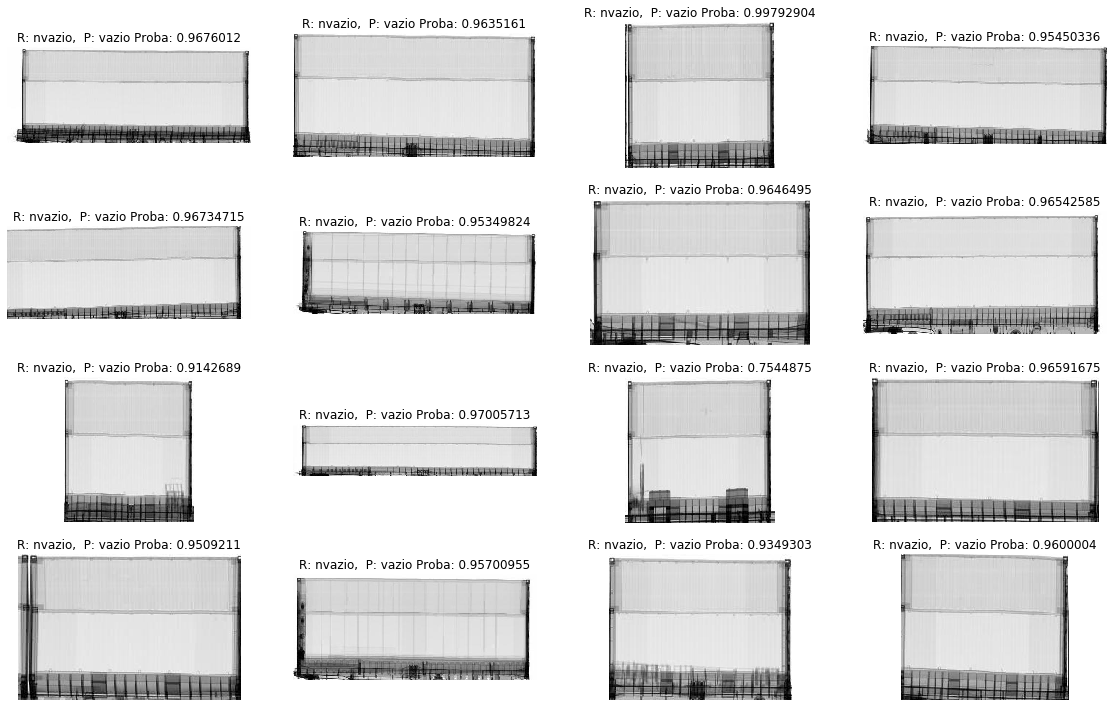

In [20]:
plot_errors(train_generator, y_train, y_pred_train, caminho_traint, X_names_train, y_pred_train_proba)

In [21]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from tensorflow.keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    number_size = 4.0
    if K.floatx() == 'float16':
         number_size = 2.0
    if K.floatx() == 'float64':
         number_size = 8.0

    total_memory = number_size*(batch_size*shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

In [22]:
get_model_memory_usage(1, model)

0.014